# Mood Trend Prediction

A notebook that will take your mood data from Daylio app and make predictions based on it using a machine learning model.

## Problem Statement

**Objective:** To predict what mood would the user be for the next days. <br> A dashboard summarizing this can also help which is focused on people with Bipolar Disorder.

**Performance Measure:** RMSE and MAE

:**Assumption:** This is a regression problem because my data is daily. I need to get the scale of my mood each day and predict patterns to help me with my bipolar disorder.

## Data Preparation

### Scripts for loading the data

In [1]:
# get the data from daylio app
import pandas as pd
import numpy as np

# will be modified accordingly after deploying this
def load_mood_data():
    csv_path = "daylio_export_2024_08_14.csv"
    return pd.read_csv(csv_path)

mood = load_mood_data()

In [2]:
# prepare the data before pre-processing
def process_mood_data(mood):
  mood = mood.drop(["note_title", "note"], axis=1)
  mood["full_date"] = pd.to_datetime(mood["full_date"])
  mood = mood.set_index("full_date")
  return mood

mood = process_mood_data(mood)

### Check the data structure

In [3]:
# look at the data structure
mood.head()

,date,weekday,time,mood,activities
full_date,,,,,
2024-08-13,13 Aug,Tuesday,22:46,meh,relax | movies | hobby
2024-08-12,12 Aug,Monday,22:14,meh,grind
2024-08-11,11 Aug,Sunday,21:27,meh,sleep early | hobby
2024-08-10,10 Aug,Saturday,20:00,rad,grind
2024-08-09,9 Aug,Friday,20:22,awful,school | grind


In [4]:
mood.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 542 entries, 2024-08-13 to 2023-02-23
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        542 non-null    object
 1   weekday     542 non-null    object
 2   time        542 non-null    object
 3   mood        542 non-null    object
 4   activities  500 non-null    object
dtypes: object(5)
memory usage: 25.4+ KB


In [5]:
# check the entries for each day
mood['weekday'].value_counts()

weekday
Thursday     79
Monday       78
Friday       78
Tuesday      77
Sunday       77
Saturday     77
Wednesday    76
Name: count, dtype: int64

In [6]:
# check the mood counts per category
mood['mood'].value_counts()

mood
good     385
meh      129
bad       15
awful      7
rad        6
Name: count, dtype: int64

In [7]:
# check the activities associated to the mood
mood['activities'].value_counts()

activities
grind                                        86
school | grind                               49
friends | school                             38
friends | grind                              26
school                                       24
                                             ..
friends | relax | shopping | school           1
reading | sleep early | self-love | hobby     1
family | sleep early | grind | hobby          1
friends | school | grind | hobby              1
competition                                   1
Name: count, Length: 123, dtype: int64

In [8]:
# statistical summary of the data
mood.describe()

,date,weekday,time,mood,activities
count,542,542,542,542,500
unique,366,7,217,5,123
top,10 Aug,Thursday,23:59,good,grind
freq,3,79,81,385,86


### Create a Test Set before pre-processing

In [9]:
# create a test set
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

def create_time_series_splits(data, n_splits=5, random_seed=None):
  """
  Creates time series splits for training and testing.

  Args:
    data: The time series data (pandas DataFrame or Series).
    n_splits: The number of splits to create.
    random_seed: (Optional) Seed for random number generator for reproducibility.

  Returns:
    A generator yielding tuples of (train_data, test_data) for each split.
  """
  if random_seed is not None:
    np.random.seed(random_seed)

  tscv = TimeSeriesSplit(n_splits=n_splits)
  for train_index, test_index in tscv.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]
    yield train_data, test_data

# Example usage with a random seed for reproducibility:
for train_data, test_data in create_time_series_splits(mood, random_seed=42):
  # Train your model on train_data, evaluate on test_data
  print("Train data shape:", train_data.shape)
  print("Test data shape:", test_data.shape)

Train data shape: (92, 5)
Test data shape: (90, 5)
Train data shape: (182, 5)
Test data shape: (90, 5)
Train data shape: (272, 5)
Test data shape: (90, 5)
Train data shape: (362, 5)
Test data shape: (90, 5)
Train data shape: (452, 5)
Test data shape: (90, 5)


## Exploratory Data Analysis

In [10]:
# make a copy of the training set
mood_copy = train_data.copy()

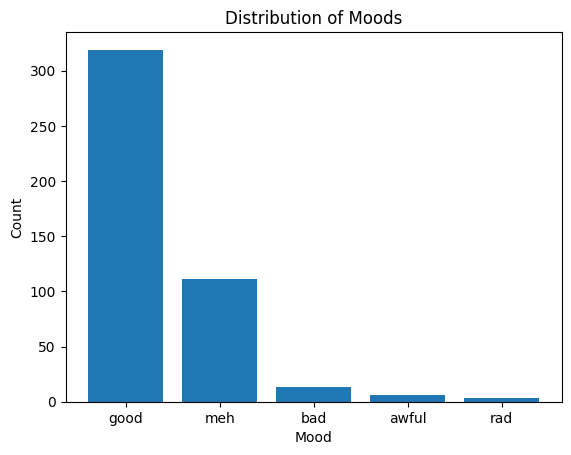

In [11]:
# visualize distribution of moods
import matplotlib.pyplot as plt

# Count the occurrences of each mood category
mood_counts = mood_copy['mood'].value_counts()

# Create a bar chart
plt.bar(mood_counts.index, mood_counts.values)
plt.xlabel('Mood')
plt.ylabel('Count')
plt.title('Distribution of Moods')
plt.show()

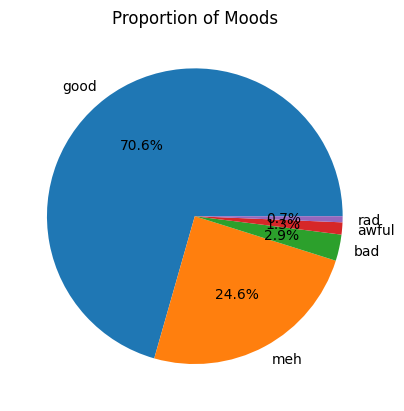

In [12]:
# visualize proportion of moods

# Calculate proportions for each mood category
mood_proportions = mood_counts / mood_counts.sum()

# Create a pie chart
plt.pie(mood_proportions, labels=mood_proportions.index, autopct='%1.1f%%')
plt.title('Proportion of Moods')
plt.show()

In [13]:
# install required package for the researchpy
!pip install -q --upgrade researchpy

In [14]:
# look for correlations of the categorical values
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import researchpy as rp

crosstab, test_results, expected = rp.crosstab(mood_copy['mood'], mood_copy['weekday'],
                                               test="chi-square",
                                               expected_freqs=True,
                                               prop="cell")

cramers_v = test_results['results'][2]
# Correct way to get degrees of freedom:
degrees_of_freedom = (len(crosstab.index) - 1) * (len(crosstab.columns) - 1)

print("Cramer's V:", cramers_v)
print("Degrees of Freedom:", degrees_of_freedom)

Cramer's V: 0.127
Degrees of Freedom: 35


**Interpretation:** Given the weak association indicated by Cramer's V and the relatively high degrees of freedom, it suggests that while there is some relationship between the categorical variables, it may not be strong or meaningful in a practical context.

In [15]:
# count the number of each mood for each month
mood_copy['month'] = mood_copy.index.to_period('M')
monthly_mood_counts = mood_copy.groupby('month')['mood'].value_counts().unstack(fill_value=0)
print(monthly_mood_counts)

mood     awful  bad  good  meh  rad
month                              
2023-05      0    0     5    3    0
2023-06      0    2    16   11    1
2023-07      0    1    25    6    0
2023-08      1    1    27    3    0
2023-09      0    1    22    7    0
2023-10      0    0    22    9    0
2023-11      1    2    19    9    0
2023-12      0    0    24    8    0
2024-01      1    1    27    2    0
2024-02      0    0    25    4    0
2024-03      0    2    25    4    0
2024-04      1    1    19    9    0
2024-05      1    1    11   18    0
2024-06      0    0    18   11    1
2024-07      0    1    28    2    0
2024-08      1    0     6    5    1


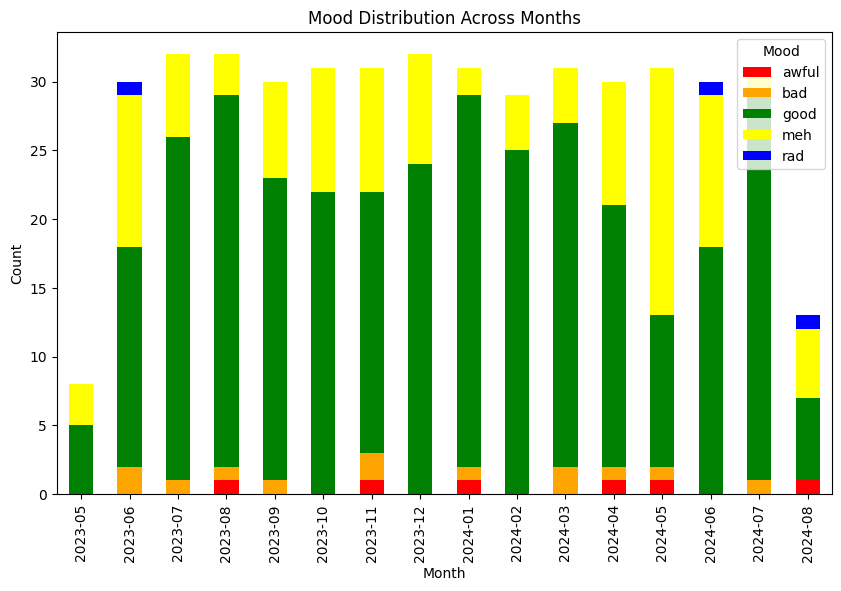

In [16]:
# visualize mood distribution across months
colors = {'awful': 'red', 'bad': 'orange', 'good': 'green', 'meh': 'yellow', 'rad': 'blue'}
monthly_mood_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors[c] for c in monthly_mood_counts.columns])
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Mood Distribution Across Months')
plt.legend(title='Mood')
plt.show()

**Next step:** Handle the categorical values by encoding them.

## Data Preprocessing

I have created a class to make data preprocessing more streamlined.

In [17]:
# import all the necessary packages
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

In [20]:
# data preprocessor class which includes: general preprocessing, feature engineering, feature transformation, feature scaling, and data augmentation
# check the other notebook for the in-depth workings of this class

class DataPreprocessor:
    def __init__(self, mood_mapping=None):
        if mood_mapping is None:
            self.mood_mapping = {'good': 3, 'rad': 4, 'meh': 2, 'awful': 0, 'bad': 1}
        else:
            self.mood_mapping = mood_mapping
        self.pt = PowerTransformer(method='yeo-johnson')
        self.scaler = StandardScaler()
        self.columns_to_scale = ['tf_mood_encoded_lag1', 'tf_mood_rolling_mean_14']
    
    def preprocess_mood_data(self, data):
        """
        Preprocesses the mood data, separating the target column.

        Args:
            data (pd.DataFrame): The input data (either training or test data).

        Returns:
            pd.DataFrame: The preprocessed features.
            pd.Series: The target variable.
        """
        mood_copy = data.copy()

        # Initial processing
        mood_copy = mood_copy.dropna(subset=['activities'])
        mood_copy['mood_encoded'] = mood_copy['mood'].map(self.mood_mapping)
        mood_copy = mood_copy.drop(['date', 'activities', 'mood'], axis=1)

        # Separate target
        target = mood_copy['mood_encoded']

        return mood_copy, target

    def feature_engineering_and_visualization(self, mood_copy):
        """
        Performs feature engineering and visualization on the mood data.

        Args:
            mood_copy (pd.DataFrame): The preprocessed mood data.

        Returns:
            pd.DataFrame: The mood data with engineered features.
        """
        mood_copy['mood_encoded_lag1'] = mood_copy['mood_encoded'].shift(1)
        mood_copy['mood_encoded_lag1'] = mood_copy['mood_encoded_lag1'].fillna(method='bfill')
        mood_copy['time_diff'] = mood_copy.index.to_series().diff().dt.days
        mood_copy['mood_rolling_mean_14'] = mood_copy['mood_encoded'].rolling(window=14).mean()

        plt.figure(figsize=(10, 6))
        plt.plot(mood_copy.index, mood_copy['mood_encoded'], label='Original Mood')
        plt.plot(mood_copy.index, mood_copy['mood_rolling_mean_14'], label='14-Day Rolling Mean')

        plt.xlabel('Date')
        plt.ylabel('Mood Score')
        plt.title('Rolling Average of Mood Scores')
        plt.legend()
        plt.grid(True)
        plt.show()

        mood_copy['mood_rolling_mean_14'] = mood_copy['mood_rolling_mean_14'].fillna(method='bfill', limit=1)
        mood_copy['mood_rolling_mean_14'] = mood_copy['mood_rolling_mean_14'].interpolate(method='linear')
        
        mood_copy = mood_copy.dropna()

        self._visualize_numerical_distribution(mood_copy)

        return mood_copy


    def power_transform_and_visualize(self, mood_copy, is_train=True):
        """
        Applies power transformation to the specified features and visualizes the transformed features.

        Args:
            mood_copy (pd.DataFrame): The mood data with engineered features.
            is_train (bool): Whether the data is training data (fit the transformer) or test data (use fitted transformer).

        Returns:
            pd.DataFrame: The mood data with transformed features.
        """
        if is_train:
            mood_copy['tf_mood_encoded'] = self.pt.fit_transform(mood_copy['mood_encoded'].values.reshape(-1, 1))
            mood_copy['tf_mood_encoded_lag1'] = self.pt.fit_transform(mood_copy['mood_encoded_lag1'].values.reshape(-1, 1))
            mood_copy['tf_mood_rolling_mean_14'] = self.pt.fit_transform(mood_copy['mood_rolling_mean_14'].values.reshape(-1, 1))
        else:
            mood_copy['tf_mood_encoded'] = self.pt.transform(mood_copy['mood_encoded'].values.reshape(-1, 1))
            mood_copy['tf_mood_encoded_lag1'] = self.pt.transform(mood_copy['mood_encoded_lag1'].values.reshape(-1, 1))
            mood_copy['tf_mood_rolling_mean_14'] = self.pt.transform(mood_copy['mood_rolling_mean_14'].values.reshape(-1, 1))

        columns_to_drop = ['mood_encoded', 'mood_encoded_lag1', 'mood_rolling_mean_14']
        mood_copy = mood_copy.drop(columns_to_drop, axis=1)

        self._visualize_transformed_features(mood_copy)

        return mood_copy

    def scale_features(self, mood_copy, is_train=True):
        """
        Scales the specified features using StandardScaler.

        Args:
            mood_copy (pd.DataFrame): The mood data with transformed features.
            is_train (bool): Whether the data is training data (fit the scaler) or test data (use fitted scaler).

        Returns:
            pd.DataFrame: The mood data with scaled features.
        """
        if is_train:
            mood_copy[self.columns_to_scale] = self.scaler.fit_transform(mood_copy[self.columns_to_scale])
        else:
            mood_copy[self.columns_to_scale] = self.scaler.transform(mood_copy[self.columns_to_scale])
        return mood_copy

    def apply_jittering_and_visualize(self, mood_copy):
        """
        Applies jittering to the specified features and visualizes the jittered features.

        Args:
            mood_copy (pd.DataFrame): The mood data with scaled features.

        Returns:
            pd.DataFrame: The mood data with jittered features.
        """
        mood_aug_1 = mood_copy.copy()

        noise = np.random.normal(0, 0.2, size=mood_aug_1['tf_mood_encoded'].shape)
        mood_aug_1['tf_mood_encoded_jittered'] = mood_aug_1['tf_mood_encoded'] + noise

        plt.figure(figsize=(10, 6))
        plt.plot(mood_aug_1.index, mood_aug_1['tf_mood_encoded'], label='Original Mood (Transformed)')
        plt.plot(mood_aug_1.index, mood_aug_1['tf_mood_encoded_jittered'], label='Jittered Mood (Transformed)', alpha=0.7)

        plt.xlabel('Date')
        plt.ylabel('Mood Score (Transformed)')
        plt.title('Effect of Jittering on Transformed Mood Data')
        plt.legend()
        plt.grid(True)
        plt.show()

        self._visualize_augmented_features(mood_aug_1)

        return mood_aug_1

    def _visualize_numerical_distribution(self, mood_copy):
        numerical_columns = mood_copy.select_dtypes(include=['number']).columns
        for column in numerical_columns:
            plt.figure()
            plt.hist(mood_copy[column], bins=20)
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.title(f'Distribution of {column}')
            plt.grid(True)
            plt.show()

    def _visualize_transformed_features(self, mood_copy):
        scaled_columns = ['tf_mood_encoded', 'tf_mood_encoded_lag1', 'tf_mood_rolling_mean_14']
        for column in scaled_columns:
            plt.figure()
            plt.hist(mood_copy[column], bins=20)
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.title(f'Distribution of {column}')
            plt.grid(True)
            plt.show()

    def _visualize_augmented_features(self, mood_aug_1):
        scaled_columns = ['tf_mood_encoded', 'tf_mood_encoded_jittered']
        for column in scaled_columns:
            plt.figure()
            plt.hist(mood_aug_1[column], bins=20)
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.title(f'Distribution of {column}')
            plt.grid(True)
            plt.show()

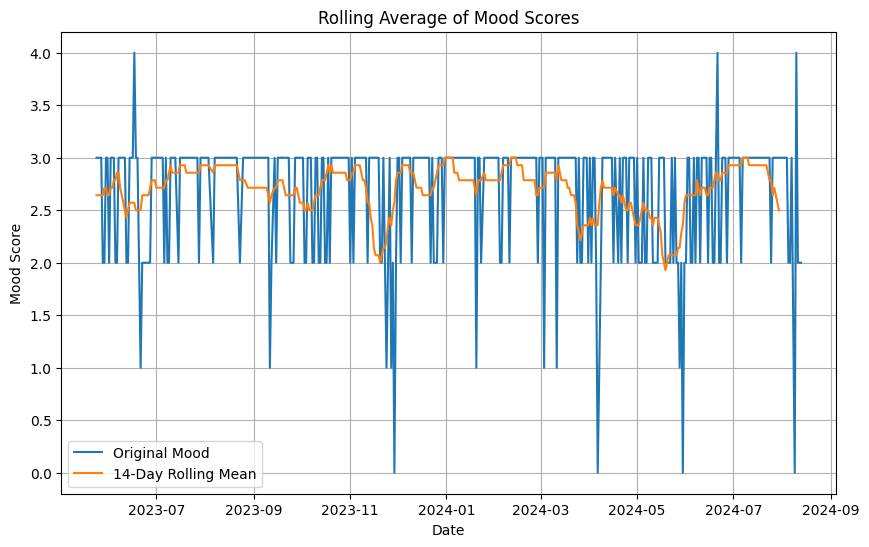

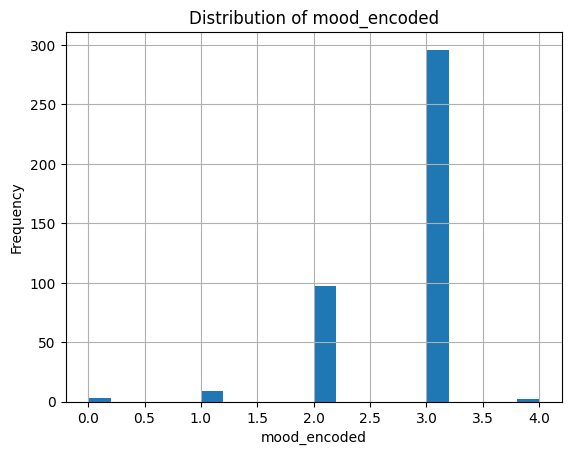

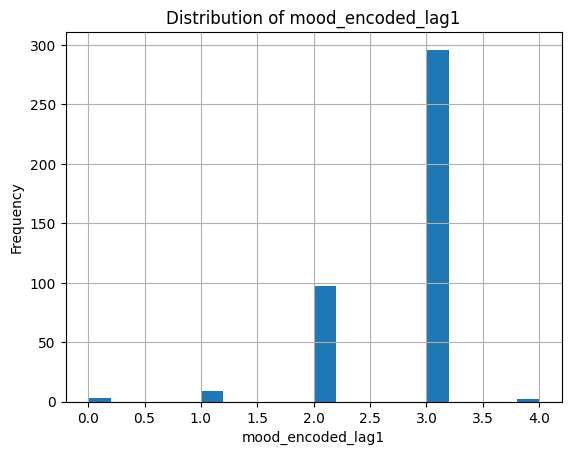

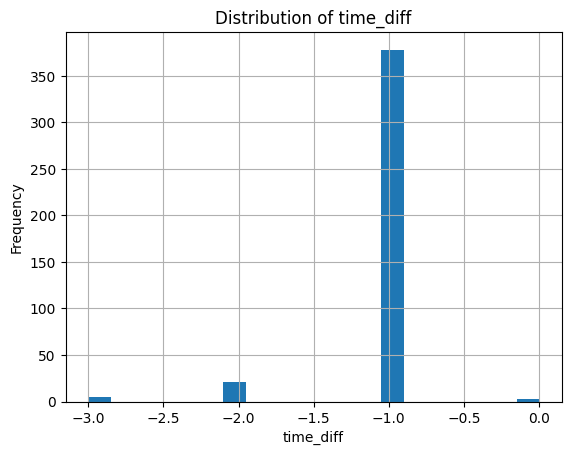

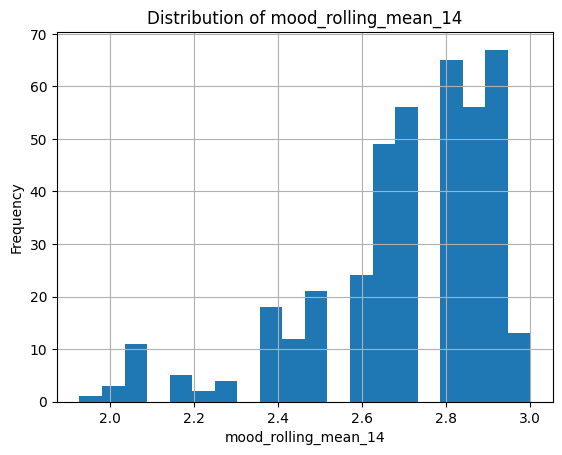

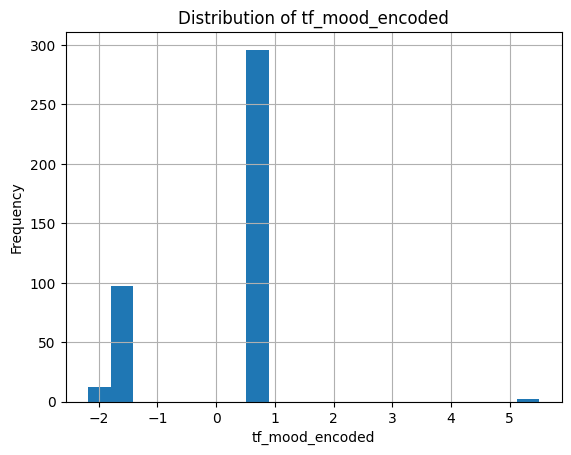

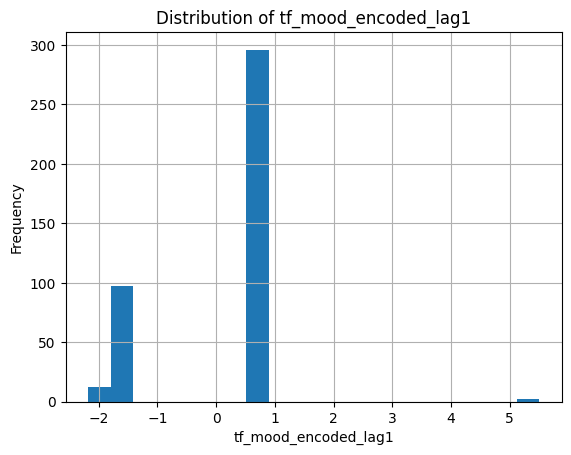

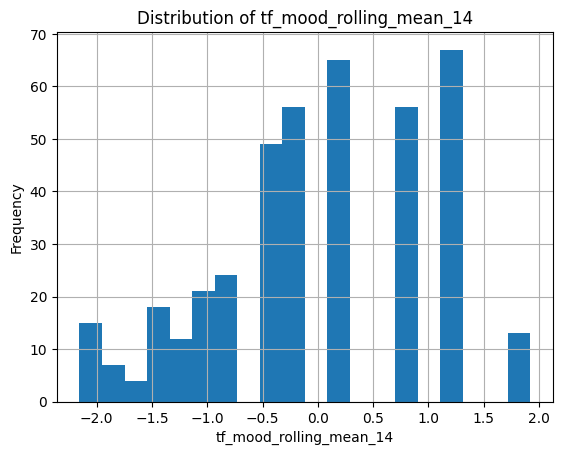

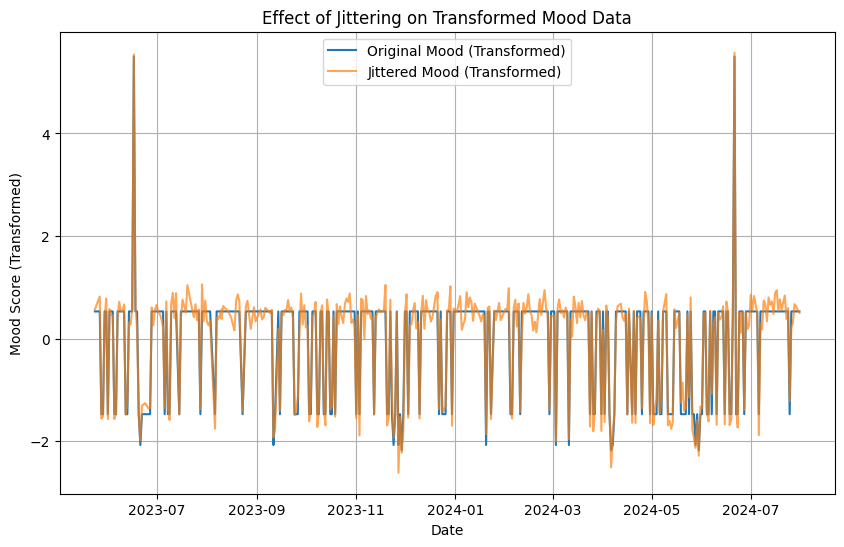

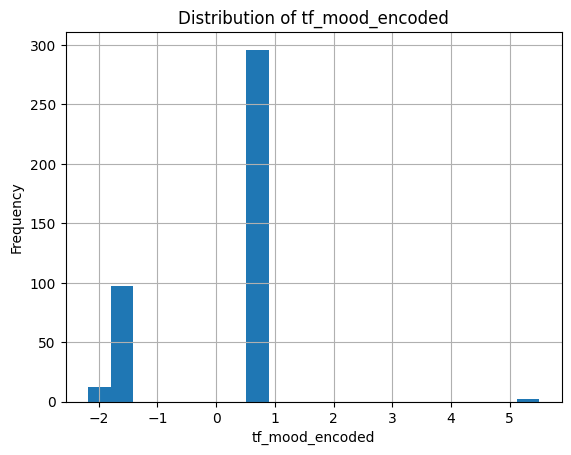

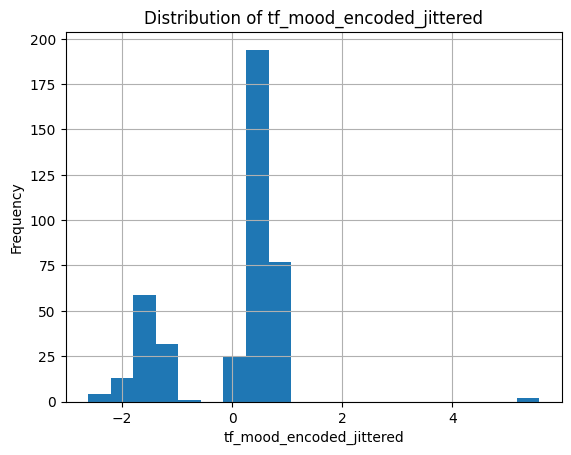

In [22]:
preprocessor = DataPreprocessor()

# Process training data
train_features, train_target = preprocessor.preprocess_mood_data(train_data)
train_features = preprocessor.feature_engineering_and_visualization(train_features)
train_features = preprocessor.power_transform_and_visualize(train_features, is_train=True)
train_features = preprocessor.scale_features(train_features, is_train=True)
train_augmented_features = preprocessor.apply_jittering_and_visualize(train_features)

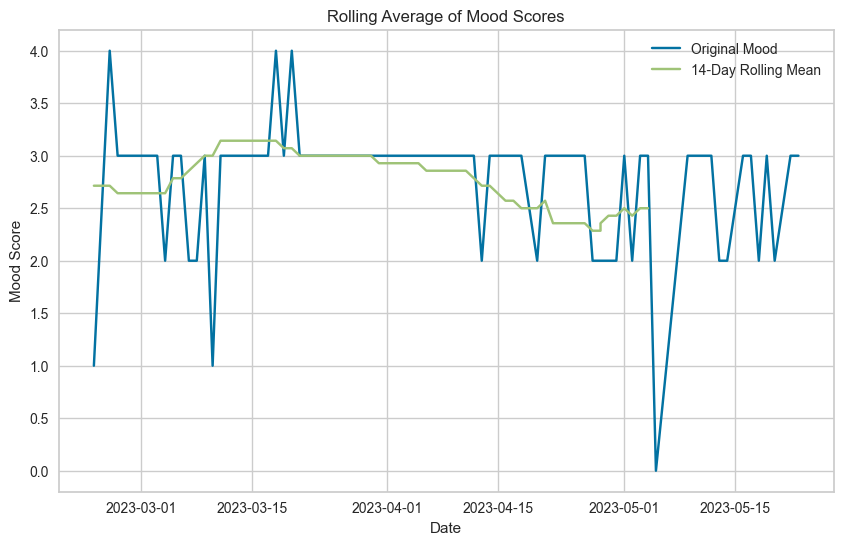

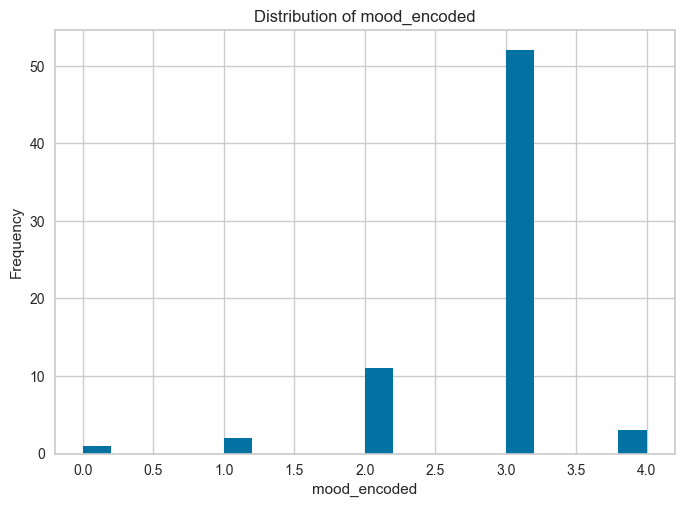

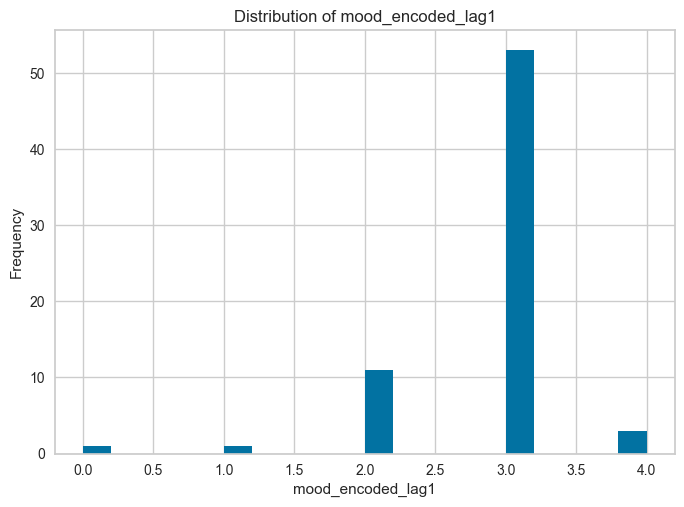

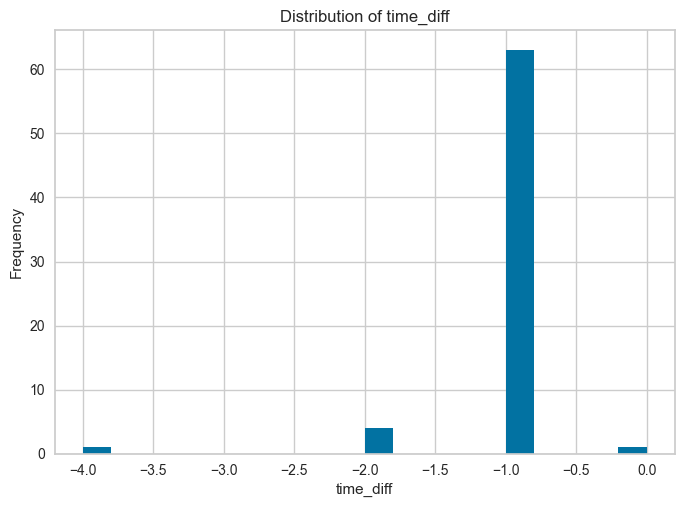

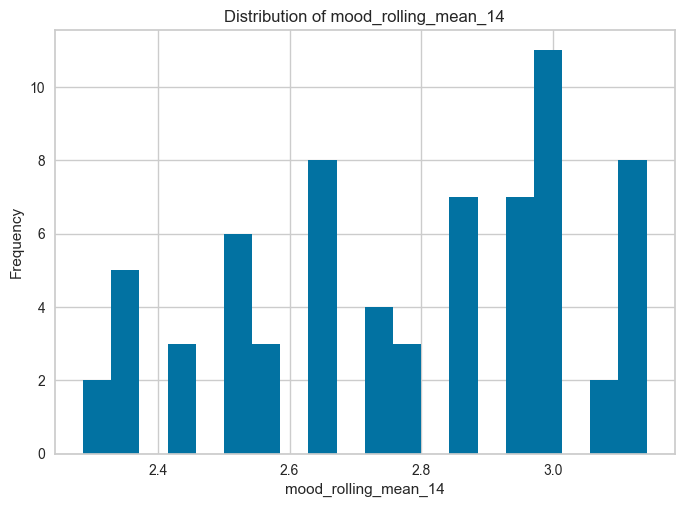

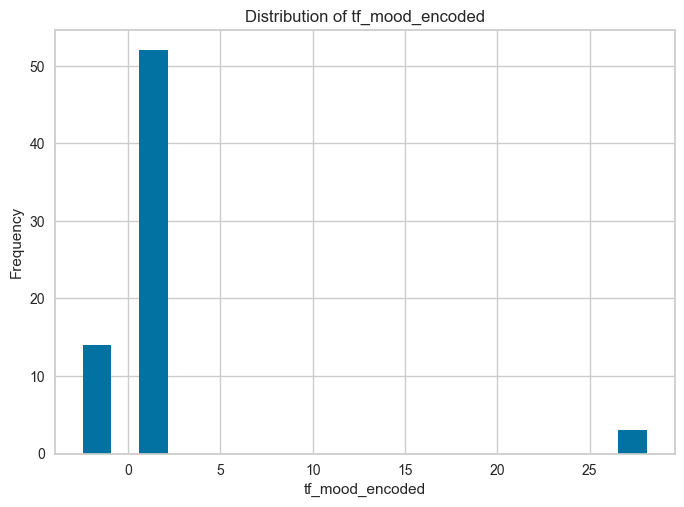

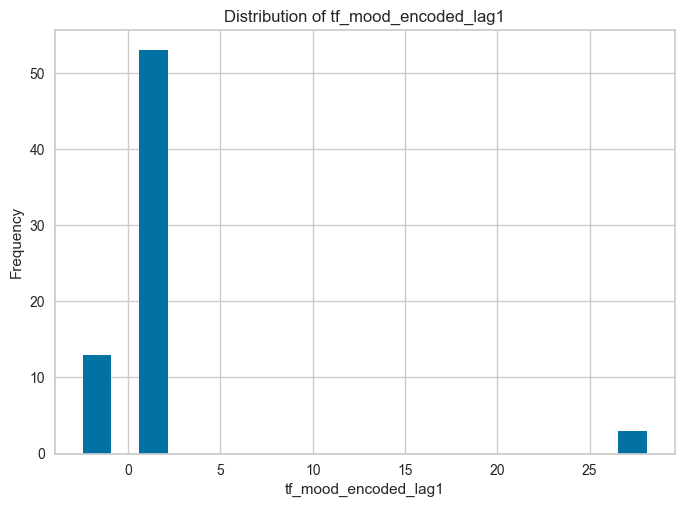

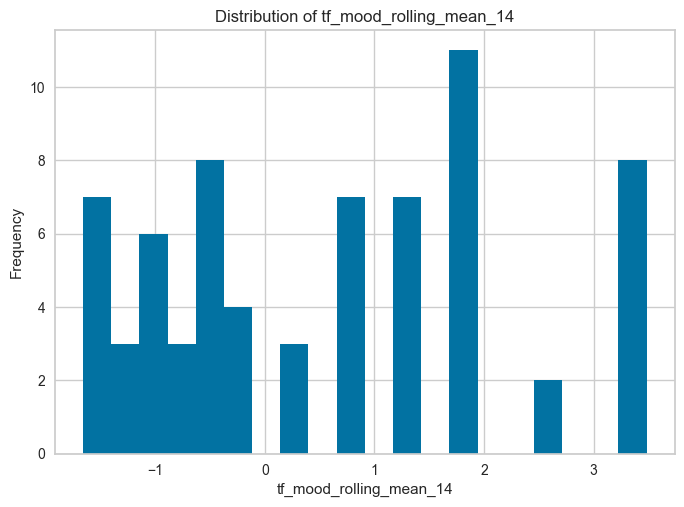

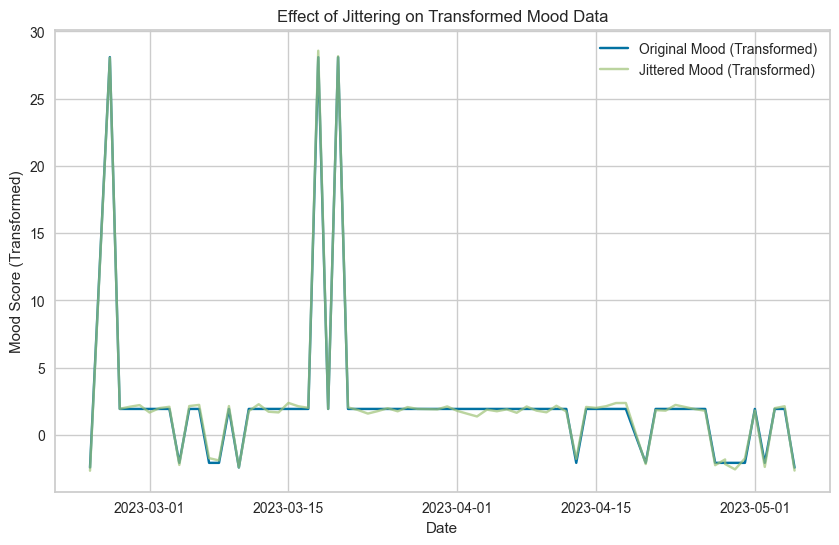

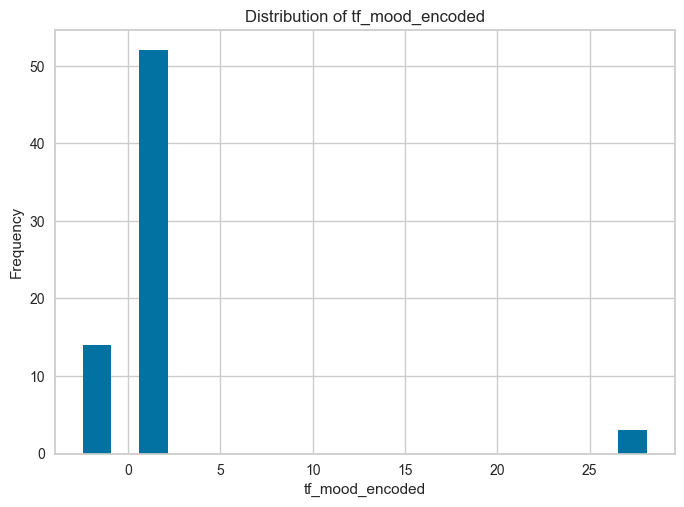

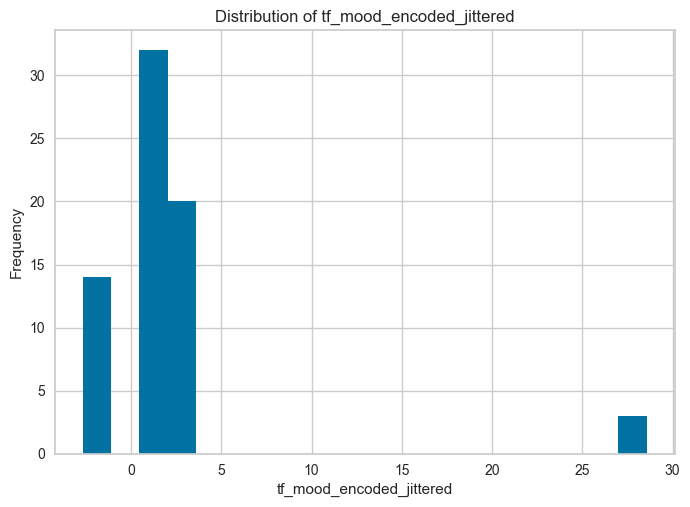

In [47]:
# Process test data
test_features, test_target = preprocessor.preprocess_mood_data(test_data)
test_features = preprocessor.feature_engineering_and_visualization(test_features)
test_features = preprocessor.power_transform_and_visualize(test_features, is_train=False)
test_features = preprocessor.scale_features(test_features, is_train=False)
test_augmented_features = preprocessor.apply_jittering_and_visualize(test_features)

## Select and Train a Model

In [24]:
!pip install -q pycaret[full]

In [30]:
train_augmented_features.head()

,weekday,time,time_diff,tf_mood_encoded,tf_mood_encoded_lag1,tf_mood_rolling_mean_14,tf_mood_encoded_jittered
full_date,,,,,,,
2024-07-31,Wednesday,20:38,-1.0,0.530479,0.530479,-1.081284,0.502003
2024-07-30,Tuesday,20:00,-1.0,0.530479,0.530479,-1.081284,0.554538
2024-07-29,Monday,20:00,-1.0,0.530479,0.530479,-0.818748,0.633367
2024-07-28,Sunday,21:57,-1.0,0.530479,0.530479,-0.512416,0.672802
2024-07-27,Saturday,20:12,-1.0,0.530479,0.530479,-0.156062,0.305551


In [33]:
# check for duplicates
duplicate_indices = train_augmented_features[train_augmented_features.index.duplicated()]
duplicate_indices

,weekday,time,time_diff,tf_mood_encoded,tf_mood_encoded_lag1,tf_mood_rolling_mean_14,tf_mood_encoded_jittered
full_date,,,,,,,
2023-12-21,Thursday,19:31,0.0,0.530479,0.530479,-0.512416,0.799563
2023-11-13,Monday,22:26,0.0,0.530479,0.530479,-0.818748,0.421107
2023-08-10,Thursday,01:31,0.0,0.530479,0.530479,1.286896,0.567832


In [34]:
# drop the duplicates
train_augmented_features = train_augmented_features.reset_index(drop=True)

In [35]:
# select a model
from pycaret.regression import *
exp_reg = setup(data = train_augmented_features, target = 'tf_mood_encoded', session_id=123)

# compare regression models
best_model = compare_models()

,Description,Value
0,Session id,123
1,Target,tf_mood_encoded
2,Target type,Regression
3,Original data shape,"(407, 7)"
4,Transformed data shape,"(407, 13)"
5,Transformed train set shape,"(284, 13)"
6,Transformed test set shape,"(123, 13)"
7,Numeric features,4
8,Categorical features,2
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.0237,0.0185,0.0994,0.9881,0.0305,0.0105,0.0510
rf,Random Forest Regressor,0.0315,0.0549,0.1426,0.9699,0.0370,0.0105,0.0920
et,Extra Trees Regressor,0.0776,0.0613,0.2012,0.9586,0.0842,0.0743,0.0740
omp,Orthogonal Matching Pursuit,0.1637,0.0411,0.1998,0.9577,0.1207,0.2464,0.0320
ridge,Ridge Regression,0.1694,0.0437,0.2061,0.9559,0.1237,0.2512,0.0360
br,Bayesian Ridge,0.1700,0.0441,0.2070,0.9556,0.1243,0.2519,0.0310
lr,Linear Regression,0.1711,0.0448,0.2086,0.9551,0.1253,0.2530,1.6130
lar,Least Angle Regression,0.1711,0.0448,0.2086,0.9551,0.1253,0.2530,0.0290
huber,Huber Regressor,0.1726,0.0453,0.2099,0.9545,0.1269,0.2566,0.0510
ada,AdaBoost Regressor,0.0325,0.0954,0.1495,0.9523,0.0472,0.0108,0.0450


The best model according to pycaret is: **Gradient Boosting Regressor**

In [36]:
# train and evaluate on the training set
model = create_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0259,0.0123,0.1110,0.9878,0.0397,0.0125
1,0.0188,0.0075,0.0863,0.9929,0.0295,0.0099
2,0.0015,0.0001,0.0071,0.9999,0.0029,0.0010
3,0.0264,0.0108,0.1038,0.9899,0.0369,0.0143
4,0.0216,0.0130,0.1142,0.9843,0.0414,0.0104
5,0.0091,0.0017,0.0412,0.9983,0.0139,0.0052
6,0.0008,0.0000,0.0019,1.0000,0.0008,0.0008
7,0.0993,0.1228,0.3504,0.9418,0.0775,0.0299
8,0.0216,0.0129,0.1136,0.9911,0.0411,0.0147


### Interpretation

- The **mean values of MAE, MSE, and RMSE** are ***relatively low***, indicating that the model is making accurate predictions on average. <br>
- The **mean R2** is ***high***, indicating that the model explains a significant portion of the variance in the target variable. <br>
- The **mean RMSLE and MAPE** are also ***relatively low***, suggesting that the model's errors are not too large relative to the magnitude of the target variable.

### Evaluate model on the test set

In [50]:
# drop the duplicates
test_augmented_features = test_augmented_features.reset_index(drop=True)

In [51]:
# Predict on the test set
predictions = predict_model(model, data=test_augmented_features)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.1335,23.7138,4.8697,0.2827,0.6493,0.6271


In [53]:
# Get the evaluation metrics
metrics = get_metrics(best_model)
print(metrics)

        Name Display Name                                     Score Function  \
ID                                                                             
mae      MAE          MAE  <function mean_absolute_error at 0x0000022D6CE...   
mse      MSE          MSE  <function mean_squared_error at 0x0000022D6CED...   
rmse    RMSE         RMSE  <function mean_squared_error at 0x0000022D6CED...   
r2        R2           R2          <function r2_score at 0x0000022D6CEDFC40>   
rmsle  RMSLE        RMSLE  <function RMSLEMetricContainer.__init__.<local...   
mape    MAPE         MAPE  <function MAPEMetricContainer.__init__.<locals...   

                                                  Scorer Target  \
ID                                                                
mae                              neg_mean_absolute_error   pred   
mse                               neg_mean_squared_error   pred   
rmse                         neg_root_mean_squared_error   pred   
r2                      

### Interpretation

- The **MAE, MSE, and RMSE** are ***relatively low***, indicating that the model is making accurate predictions on average.<br>
- The **R2** is ***moderate***, indicating that the model explains a portion of the variance in the target variable.
- The **RMSLE and MAPE** are also ***relatively low***, suggesting that the model's errors are not too large relative to the magnitude of the target variable.

## Fine Tuning

**Conclusion:**